# AI Tools for Actuaries
## Chapter 5: FNN one-hot encoding
### Authors: Michael Mayer and Mario Wuthrich
### Version April, 2025

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf  # 2.19.0
from tensorflow import keras

# See all pandas columns
pd.set_option("display.max_columns", None)

# Helps to keep results reproducible
tf.config.experimental.enable_op_determinism()

## Load data and split into fixed Learn and Test

In [2]:
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


In [3]:
learn = df[df["LearnTest"] == "L"]
test = df[df["LearnTest"] == "T"]

## Pre-processing

### Define the Scikit-Learn preprocessor

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)


def clip_and_scale(upper):
    pipe = Pipeline(
        steps=[
            ("clip", FunctionTransformer(lambda x: np.clip(x, a_min=0, a_max=upper))),
            ("scale", StandardScaler()),
        ]
    )
    return pipe


density = Pipeline(
    steps=[
        ("log", FunctionTransformer(lambda x: np.log(x).round(2))),
        ("scale", StandardScaler()),
    ]
)

area = Pipeline(
    steps=[
        ("encode", OrdinalEncoder()),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "scale",
            clip_and_scale([20, 90, 150, 15]),
            ["VehAge", "DrivAge", "BonusMalus", "VehPower"],
        ),
        ("area", area, ["Area"]),
        ("density", density, ["Density"]),
        ("veh_brand", OneHotEncoder(sparse_output=False), ["VehBrand", "Region"]),
        ("veh_gas", FunctionTransformer(lambda x: x == "Diesel"), ["VehGas"]),
    ],
    verbose_feature_names_out=False,
)

# Just a check: Fit preprocessor to training data and apply to some lines from test
preprocessor.set_output(transform="pandas").fit(learn)
preprocessor.transform(test.head())

,VehAge,DrivAge,BonusMalus,VehPower,Area,Density,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,Region_R43,Region_R52,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,VehGas
610206,-1.29173,-1.309026,1.937902,-1.196789,0.513423,0.298236,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
610207,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
610208,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
610209,-1.29173,1.663510,-0.497176,-0.709264,0.513423,0.666918,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
610210,-1.29173,0.460341,-0.625338,-0.709264,-0.209473,-0.476529,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


### Split in covariates X, responses y, exposures v

In [5]:
X_learn = preprocessor.fit_transform(learn)
X_test = preprocessor.transform(test)

y_learn, v_learn = learn.ClaimNb, learn.Exposure
y_test, v_test = test.ClaimNb, test.Exposure

## Define FNN

In [7]:
def create_fnn(seed, n_features, hidden_layers, freeze_hidden=False):
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(seed)

    design_input = keras.layers.Input(shape=(n_features,))
    volume_input = keras.layers.Input(shape=(1,))

    x = design_input

    for q in hidden_layers:
        x = keras.layers.Dense(q, activation="tanh", trainable=not freeze_hidden)(x)
    x = keras.layers.Dense(1, activation="exponential")(x)

    output = keras.layers.Multiply()([x, volume_input])

    model = keras.Model(inputs=[design_input, volume_input], outputs=output)

    return model


SEED = 100
M_FEAT = X_learn.shape[1]  # number of features
HIDDEN = [20, 15, 10]

# Create model with three hidden layers
model = create_fnn(SEED, n_features=M_FEAT, hidden_layers=HIDDEN)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        820 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │        315 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         11 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ dense_3[0][0],    │
│                     │                   │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,306 (5.10 KB)

 Trainable params: 1,306 (5.10 KB)

 Non-trainable params: 0 (0.00 B)

## Homogeneous case not considering any covariates

In [8]:
from sklearn.metrics import mean_poisson_deviance

mu_hom = learn.ClaimNb.sum() / learn.Exposure.sum()  # homogeneous frequency
w0 = model.get_weights()
w0[-2] *= 0
w0[-1][0] = np.log(mu_hom)
model.set_weights(w0)


def score(model, X, y, v):
    """Evaluate the model using sklearn's mean_poisson_deviance."""
    pred = model.predict([X, v], batch_size=int(1e6), verbose=0).flatten()
    return 100*mean_poisson_deviance(y/v, pred/v, sample_weight=v)


print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")


Poisson Deviance (Learn): 47.722
Poisson Deviance (Test): 47.967


## Train the model

In [9]:
# Callback for saving model and for implicit early stopping (~after 60-70 epochs here)
if not os.path.exists("./Networks"):
    os.makedirs("./Networks")

checkpoint_path = f"./Networks/FNN1_{SEED}.weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True
)

# Compile model
model.compile(loss="poisson", optimizer="nadam")

# Train model
history = model.fit(
    [X_learn, v_learn],
    y_learn,
    validation_split=0.1,
    batch_size=5000,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint],
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1596 - val_loss: 0.1559
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1563 - val_loss: 0.1555
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1561 - val_loss: 0.1553
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1559 - val_loss: 0.1552
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1558 - val_loss: 0.1550
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1555 - val_loss: 0.1547
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1553 - val_loss: 0.1546
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1551 - val_loss: 0.1544
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1550 - val_loss: 0.1543
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1549 - val_loss: 0.1542
Epoch 11/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1548 - val_loss: 0.1541
Epoch 12/100
110/110 ━━━━━━━━━━━━━━━━━━━━

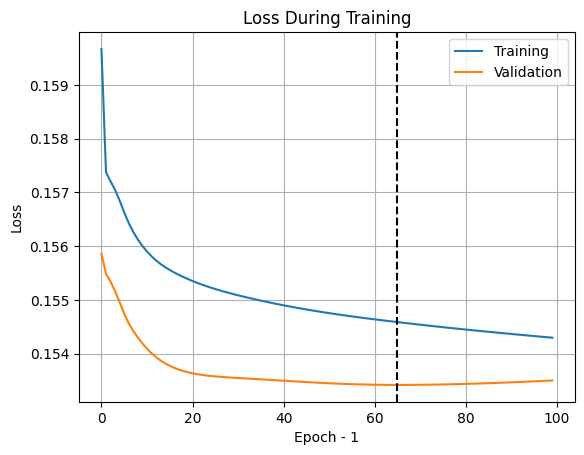

In [10]:
# Plot training history (vertical line at best validation loss)
fig = (
    pd.DataFrame(history.history)
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(
    np.argmin(model.history.history["val_loss"]), color="black", linestyle="--"
)


## Evaluate Results

In [11]:
# Load best weights and evaluate
model.load_weights(checkpoint_path)
w2 = model.get_weights()

print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

learn_nn = model.predict([X_learn, v_learn], batch_size=int(1e6), verbose=0).flatten()

print(f"Balance Property: {mu_hom:.4f} {learn_nn.sum() / learn['Exposure'].sum():.4f}")

Poisson Deviance (Learn): 44.850
Poisson Deviance (Test): 44.974
Balance Property: 0.0736 0.0733


## Balance Property Adjustment

In [12]:
# Create model that has only a trainable output layer
model = create_fnn(SEED, n_features=M_FEAT, hidden_layers=HIDDEN, freeze_hidden=True)
model.set_weights(w2)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.1544
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1544
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1544
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1544
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1543
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1543
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1543
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1543
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1543
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1543
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1543
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1543
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1543
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1543
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1543
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━

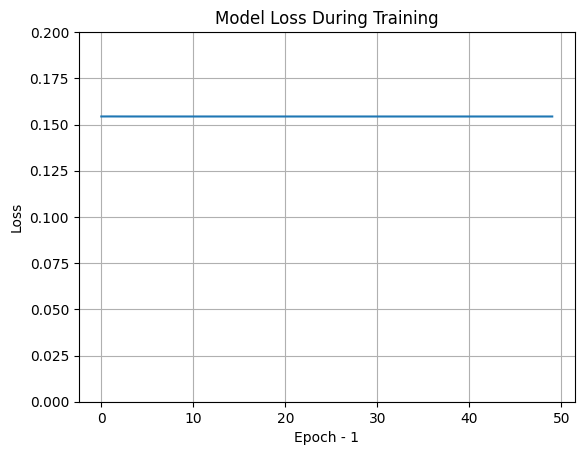

In [13]:
# Compile model
model.compile(loss="poisson", optimizer=keras.optimizers.Nadam(learning_rate=0.01))

# Train model (note that we train a Poisson model with canonical link)
history = model.fit(
    [X_learn, v_learn],
    y_learn,
    validation_split=0,
    batch_size=len(y_learn),
    epochs=50,
    verbose=1,
)

_ = pd.DataFrame(history.history).plot(
    xlabel="Epoch - 1",
    ylabel="Loss",
    title="Model Loss During Training",
    grid=True,
    legend=False,
    ylim=(0, 0.2),
)

In [15]:
print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

learn_nn_reg = model.predict(
    [X_learn, v_learn], batch_size=int(1e6), verbose=0
).flatten()

print(
    f"Balance Property: {mu_hom:.4f} {learn_nn_reg.sum() / learn['Exposure'].sum():.4f}"
)

Poisson Deviance (Learn): 44.846
Poisson Deviance (Test): 44.966
Balance Property: 0.0736 0.0736


In [16]:
path2 = f"./Networks/FNN1_reg_{SEED}.weights.h5"
model.save_weights(path2)